[*********************100%***********************]  1 of 1 completed


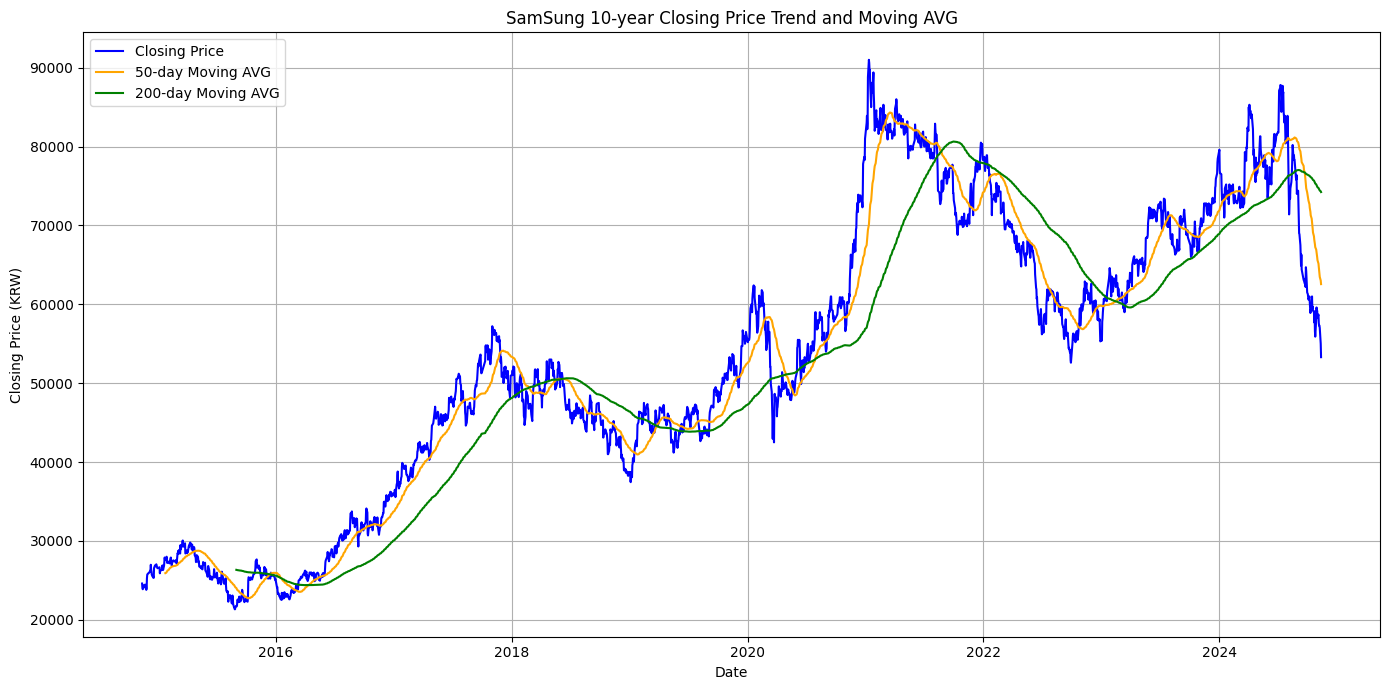

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from matplotlib import font_manager, rc


## 먹통
# font_path="C:/Users/daniel/Downloads/nanum-gothic/NanumGothic.ttf"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

## 삼성전자(Yahoo Finance 기준)
ticker = '005930.KS'

## 오늘 날짜와 10년 전 날짜 설정
end_date = datetime.today()
start_date = end_date - relativedelta(years=10)

## 데이터 가져오기
try:
    df = yf.download(ticker, start=start_date, end=end_date)
    if df.empty:
        raise ValueError("데이터 없음")
except Exception as e:
    print(f"오류 발생: {e}")
    exit()

## 종가 데이터만 추출
close_prices = df['Close']

## 이동 평균선 계산 (예: 50일, 200일)
close_prices_50 = close_prices.rolling(window=50).mean()
close_prices_200 = close_prices.rolling(window=200).mean()

## 시각화
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index, close_prices.values, label='Closing Price', color='blue')
plt.plot(close_prices_50.index, close_prices_50.values, label='50-day Moving AVG', color='orange')
plt.plot(close_prices_200.index, close_prices_200.values, label='200-day Moving AVG', color='green')
plt.title('SamSung 10-year Closing Price Trend and Moving AVG')
plt.xlabel('Date')
plt.ylabel('Closing Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2456 entries, 2014-11-12 00:00:00+00:00 to 2024-11-12 00:00:00+00:00
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (Adj Close, 005930.KS)  2456 non-null   float64
 1   (Close, 005930.KS)      2456 non-null   float64
 2   (High, 005930.KS)       2456 non-null   float64
 3   (Low, 005930.KS)        2456 non-null   float64
 4   (Open, 005930.KS)       2456 non-null   float64
 5   (Volume, 005930.KS)     2456 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.3 KB


c:\Users\daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA 모델 요약:
                               SARIMAX Results                                
Dep. Variable:              005930.KS   No. Observations:                 2456
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -20168.932
Date:                Tue, 12 Nov 2024   AIC                          40349.863
Time:                        14:53:37   BIC                          40384.699
Sample:                             0   HQIC                         40362.522
                               - 2456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0226      0.014      1.572      0.116      -0.006       0.051
ar.L2         -0.0442      0.017     -2.642      0.008      -0.077      -0.011
ar.L3         -0.0142      0.016     -

c:\Users\daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


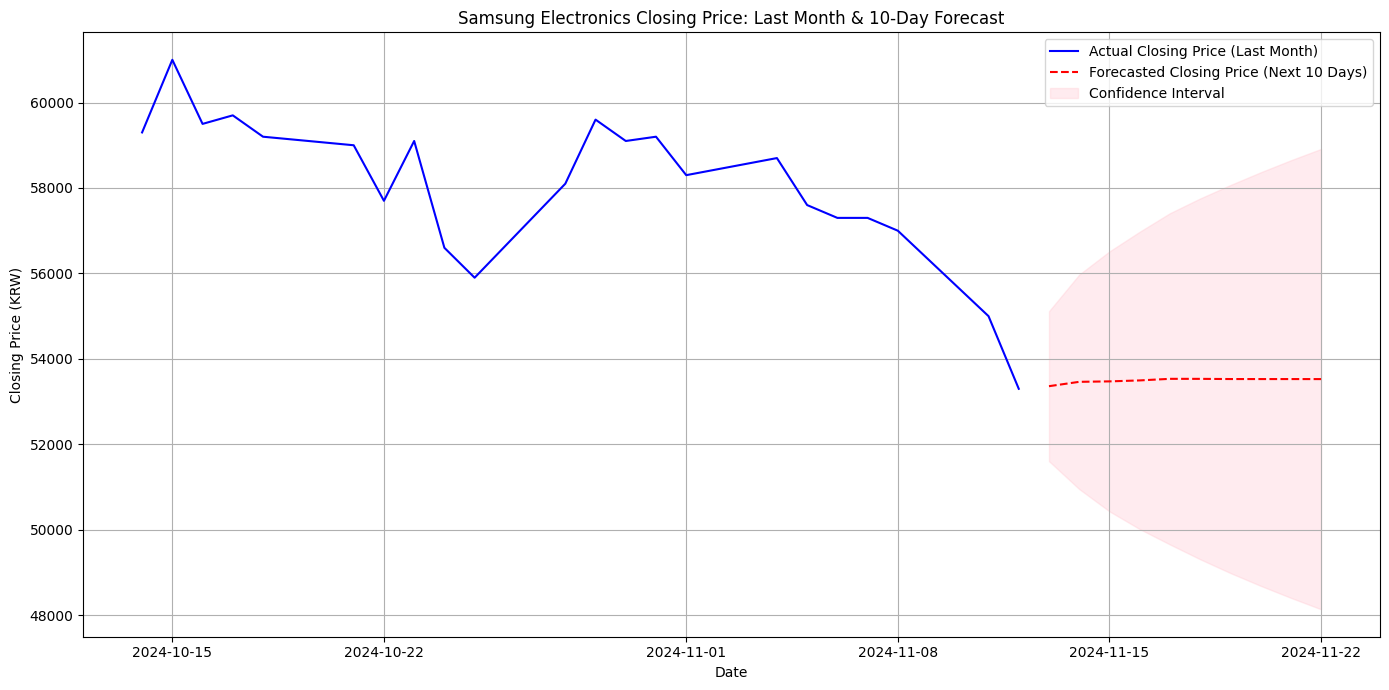


10일 뒤 예측 종가:
2024-11-13 00:00:00+00:00    53361.007897
2024-11-14 00:00:00+00:00    53462.892691
2024-11-15 00:00:00+00:00    53473.427637
2024-11-16 00:00:00+00:00    53496.018134
2024-11-17 00:00:00+00:00    53533.105273
2024-11-18 00:00:00+00:00    53532.444149
2024-11-19 00:00:00+00:00    53528.303658
2024-11-20 00:00:00+00:00    53527.703537
2024-11-21 00:00:00+00:00    53527.746530
2024-11-22 00:00:00+00:00    53526.999687
dtype: float64


In [ ]:
import statsmodels.api as sm
## ARIMA 모델
model = sm.tsa.ARIMA(close_prices, order=(5, 1, 0))  # (p,d,q) 파라미터
model_fit = model.fit()

## 모델 요약 출력
print("\nARIMA 모델 요약:")
print(model_fit.summary())

## 10일 뒤 예측
forecast_steps = 10
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

## 예측 결과의 날짜 인덱스 생성
last_date = close_prices.index[-1]
forecast_dates = [last_date + relativedelta(days=i) for i in range(1, forecast_steps + 1)]
forecast_index = pd.DatetimeIndex(forecast_dates)

## 예측값과 신뢰 구간을 데이터프레임으로 변환
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
lower_series = pd.Series(forecast_ci.iloc[:, 0].values, index=forecast_index)
upper_series = pd.Series(forecast_ci.iloc[:, 1].values, index=forecast_index)

## 최근 1개월 데이터 추출
one_month_ago = pd.Timestamp(end_date - relativedelta(months=1)).tz_localize('UTC')
recent_close = close_prices[close_prices.index >= one_month_ago]

## 시각화: 최근 1개월 종가와 예측 종가
plt.figure(figsize=(14, 7))
plt.plot(recent_close.index, recent_close.values, label='Actual Closing Price (Last Month)', color='blue')
plt.plot(forecast_series.index, forecast_series.values, label='Forecasted Closing Price (Next 10 Days)', color='red', linestyle='--')
plt.fill_between(forecast_series.index, lower_series, upper_series, color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Samsung Closing Price: Last Month & 10-day Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 예측 결과 출력
print("\n10일 뒤 예측 종가:")
print(forecast_series)